In [ ]:
import os
home = "/content"
os.chdir(home)
os.getcwd()

'/content'

In [ ]:
!pip install torch==1.6.0 torchvision==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 552.8MB 19kB/s 
     |████████████████████████████████| 5.8MB 65.0MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0+cu92 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [ ]:
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 4.5MB/s 


In [ ]:
import numpy as np
import pandas as pd

import re
import string

# Reset the output dimensions
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.metrics import f1_score, accuracy_score, hamming_loss
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset

from scipy import linalg

from collections import Counter

import pickle

import nltk
nltk.download('wordnet')
from nltk import stem
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer

from gensim import matutils, models
#from gensim.models import Word2Vec

import scipy.sparse

from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np
nltk.download('stopwords')
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

plt.rcParams['figure.figsize'] = [12, 6]
plt.style.use('seaborn-darkgrid')
import torch
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import json
from google.colab import files
uploaded = files.upload()

Saving test_seen.jsonl to test_seen.jsonl


In [ ]:
############IMPORTING TRAINING DATASET ###############
import pandas as pd
train_df= pd.read_json('train.json',lines=True)
train_df.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [ ]:
uploaded = files.upload()

Saving test_seen.jsonl to test_seen.jsonl


In [ ]:
############IMPORTING TEST DATASET ###############
import pandas as pd
test_df= pd.read_json('test_seen.jsonl',lines=True)
test_df.head()

,id,img,text
0,16395,img/16395.png,handjobs sold seperately
1,37405,img/37405.png,introducing fidget spinner for women
2,94180,img/94180.png,happy pride month let's go beat up lesbians
3,54321,img/54321.png,laughs in [majority of u.s crime rate]
4,97015,img/97015.png,finds out those 72 virgins.. are goats


In [ ]:
print("Train data shape: ",train_df.shape, "Test data shape: ",test_df.shape)

Train data shape:  (8500, 4) Test data shape:  (1000, 3)


In [ ]:
uploaded = files.upload()

Saving dev_seen.jsonl to dev_seen.jsonl


In [ ]:
############IMPORTING VALIDATION DATASET ###############
import pandas as pd
val_df= pd.read_json('dev_seen.jsonl',lines=True)
val_df.head()

,id,img,label,text
0,8291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,3745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime


Text(0.5, 1.0, 'Number of offensive and non-offensive texts')

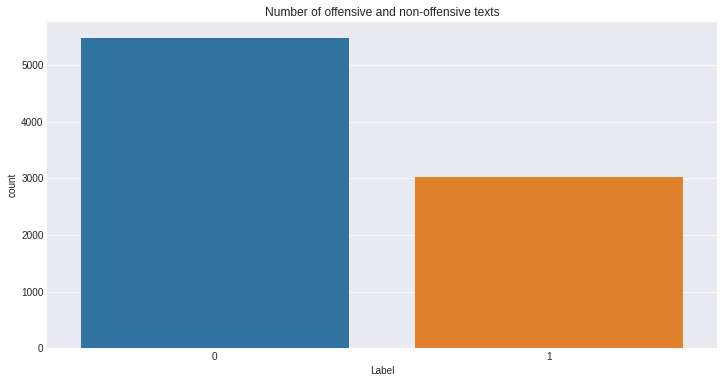

In [ ]:
sns.countplot(train_df.label)
plt.xlabel('Label')
plt.title('Number of offensive and non-offensive texts')


In [ ]:
#Concatenating train and validation dataset to build the model
train_data = pd.concat([train_df, val_df])
train_data.head(10)

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."
5,16952,img/16952.png,0,go sports! do the thing! win the points!
6,76932,img/76932.png,0,fine you're right. now can we fucking drop it?
7,70914,img/70914.png,1,tattoos are bad for your health i know 5 milli...
8,2973,img/02973.png,0,how long can i run? till the chain tightens
9,58306,img/58306.png,0,what is he hiding? we need to see his tax retu...


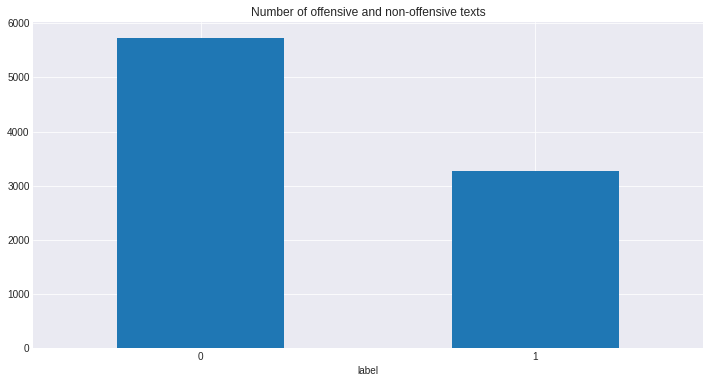

In [ ]:
train_df = train_data[['label','text']]
train_df = train_df.sort_values(by=['label'])

ax = train_df.groupby('label').count().plot(kind = 'bar', title='Number of offensive and non-offensive texts', legend=False)
ax = ax.set_xticklabels(['0', '1'], rotation=0)

In [ ]:
train_df.shape

(9000, 2)

In [ ]:
##### CLEANING THE DATA #####

def cleaning(text):        
    # converting to lowercase, removing URL links, special characters, punctuations...
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)     
    # removing the emojies              
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)   
    
    # removing the stop-words          
    text_tokens = word_tokenize(text)
    stop_words = stopwords.words()
    tokens_without_sw = [word for word in text_tokens if not word in stop_words]
    filtered_sentence = (" ").join(tokens_without_sw)
    text = filtered_sentence
    
    return text
train_df['processed_text'] = train_df['text'].apply(cleaning)
print(train_df['processed_text'])

0                                 character color matters
5190                                            look meme
5189    digging something hard guess necrophilia isnt ...
5188                    quick need get russ hey donny wtf
5187                  would racist everyone created equal
                              ...                        
6492    somehow went american hating radical muslim an...
6494         forget lock ur basement ur pets try run away
6495                                     kick islam india
1455    whats difference boy scouts jews boy scouts ba...
3428                            hands look like look like
Name: processed_text, Length: 9000, dtype: object


In [ ]:
count = 0
for row in train_df.itertuples():
  print("Text:", row[2])
  print("Processed:", row[3])
  count+=1
  if count>10:
    break

Text: its their character not their color that matters
Processed: character color matters
Text: look at me this is my meme now
Processed: look meme
Text: digging up something to do is hard guess necrophilia isn't for everyone
Processed: digging something hard guess necrophilia isnt everyone
Text: "quick, you need to get me to russ..." hey, donny "wtf!
Processed: quick need get russ hey donny wtf
Text: this would be racist but everyone is created equal
Processed: would racist everyone created equal
Text: you know like when the tv doesn't work you give it a hard hit and then its all better
Processed: know like tv doesnt work give hard hit better
Text: we don't want affordable health care! we demand tax cuts for billionaires!
Processed: dont affordable health demand tax cuts billionaires
Text: the military finally captured the massive orangutan
Processed: military finally captured massive orangutan
Text: when she on top & you trynna catch a titty
Processed: top trynna catch titty
Text: my

In [ ]:
print(train_df.groupby('label').count())

       text  processed_text
label                      
0      5734            5734
1      3266            3266


In [ ]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_df['unique_word_count'] = train_df['text'].apply(lambda x: len(set(str(x).split())))
test_df['unique_word_count'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

# mean_word_length
train_df['mean_word_length'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['char_count'] = test_df['text'].apply(lambda x: len(str(x)))


In [ ]:
train_data = train_df.copy()

label = {0: 'A', 1: 'B'}  #A- NON OFFENSIVE , B- OFFENSIVE
train_df['label'] = train_df['label'].map(label)


train_df = pd.get_dummies(train_df, columns = ['label'])
train_df.head()

,text,processed_text,label_A,label_B
0,its their character not their color that matters,character color matters,1,0
5190,look at me this is my meme now,look meme,1,0
5189,digging up something to do is hard guess necro...,digging something hard guess necrophilia isnt ...,1,0
5188,"""quick, you need to get me to russ..."" hey, do...",quick need get russ hey donny wtf,1,0
5187,this would be racist but everyone is created e...,would racist everyone created equal,1,0


In [ ]:
categories = ['label_A', 'label_B']

train_dict = {}

for column in categories:
    a = train_df.loc[train_df[column] == 1, 'text'].tolist()
    train_dict[column] = ' '.join(a)

In [ ]:
# We can either keep it in dictionary format or put it into a pandas dataframe

data_df = pd.DataFrame(train_dict.items())
data_df.columns = ['index', 'text']
data_df = data_df.set_index('index')
data_df = data_df.sort_index()
data_df.head()

,text
index,
label_A,its their character not their color that matte...
label_B,"actually retard, the muslims aren't the proble..."


In [ ]:
data_df = pd.DataFrame(data_df['text'].apply(lambda x: cleaning(x)))
data_clean = data_df.copy()
data_df.head()

,text
index,
label_A,character color matters look meme digging some...
label_B,actually retard muslims arent problem problem ...


In [ ]:
cv = CountVectorizer(stop_words = 'english')
data_cv = cv.fit_transform(data_df['text'])
data_dtm = pd.DataFrame(data_cv.toarray(), columns = cv.get_feature_names())
data_dtm.index = data_df.index
data_dtm = data_dtm.transpose()
data_dtm.head()

index,label_A,label_B
000,4,0
010819,1,0
015,1,0
0mar,1,0
10,15,6


**EXPLORATORY DATA ANALYSIS**

In [ ]:
# Find the top 30 words on each category

top_dict = {}
for c in data_dtm.columns:
    top = data_dtm[c].sort_values(ascending = False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'label_A': [('like', 368),
  ('dont', 309),
  ('people', 280),
  ('youre', 241),
  ('time', 143),
  ('day', 142),
  ('got', 142),
  ('look', 133),
  ('white', 130),
  ('fuck', 126),
  ('make', 123),
  ('shit', 120),
  ('know', 118),
  ('black', 112),
  ('trump', 107),
  ('new', 104),
  ('love', 98),
  ('think', 97),
  ('good', 91),
  ('going', 85),
  ('life', 84),
  ('need', 80),
  ('say', 78),
  ('kids', 77),
  ('said', 76),
  ('thats', 75),
  ('goat', 74),
  ('home', 73),
  ('right', 70),
  ('america', 70)],
 'label_B': [('people', 206),
  ('black', 181),
  ('white', 168),
  ('like', 148),
  ('muslim', 126),
  ('muslims', 113),
  ('dont', 100),
  ('youre', 91),
  ('kill', 82),
  ('jews', 73),
  ('fuck', 67),
  ('look', 66),
  ('women', 65),
  ('got', 65),
  ('know', 64),
  ('tranny', 63),
  ('islam', 59),
  ('shit', 54),
  ('goat', 51),
  ('make', 50),
  ('hate', 50),
  ('time', 49),
  ('gay', 46),
  ('new', 41),
  ('girl', 40),
  ('day', 39),
  ('fucking', 38),
  ('dishwasher', 38)

In [ ]:
# Print the top 15 words said by each category

for category, top_words in top_dict.items():
    print(category + ":")
    print(', '.join([word for word, count in top_words[0:14]]))
    print('-----------------------------------------------------------------------------------------------------------------------')

label_A:
like, dont, people, youre, time, day, got, look, white, fuck, make, shit, know, black
-----------------------------------------------------------------------------------------------------------------------
label_B:
people, black, white, like, muslim, muslims, dont, youre, kill, jews, fuck, look, women, got
-----------------------------------------------------------------------------------------------------------------------


In [ ]:
# Let's first pull out the top words for each category

words = []
for category in data_dtm.columns:
    top = [word for (word, count) in top_dict[category]]
    for t in top:
        words.append(t)
        
words

# Let's aggregate this list and identify the most common words along with how many routines they occur in
Counter(words).most_common()

[('like', 2),
 ('dont', 2),
 ('people', 2),
 ('youre', 2),
 ('time', 2),
 ('day', 2),
 ('got', 2),
 ('look', 2),
 ('white', 2),
 ('fuck', 2),
 ('make', 2),
 ('shit', 2),
 ('know', 2),
 ('black', 2),
 ('new', 2),
 ('think', 2),
 ('goat', 2),
 ('trump', 1),
 ('love', 1),
 ('good', 1),
 ('going', 1),
 ('life', 1),
 ('need', 1),
 ('say', 1),
 ('kids', 1),
 ('said', 1),
 ('thats', 1),
 ('home', 1),
 ('right', 1),
 ('america', 1),
 ('muslim', 1),
 ('muslims', 1),
 ('kill', 1),
 ('jews', 1),
 ('women', 1),
 ('tranny', 1),
 ('islam', 1),
 ('hate', 1),
 ('gay', 1),
 ('girl', 1),
 ('fucking', 1),
 ('dishwasher', 1),
 ('trash', 1)]

In [ ]:
data_dtm

index,label_A,label_B
000,4,0
01,0,1
010819,1,0
015,1,0
0mar,1,0
...,...,...
zone,4,0
zoo,2,0
zoos,1,0
zuckerberg,3,1


In [ ]:
# Find the number of unique words that each category has

# Identify the non-zero items in the document-term matrix, meaning that the word occurs at least once
unique_list = []
for category in data_dtm.columns:
    uniques = data_dtm[category].to_numpy().nonzero()[0].size
    unique_list.append(uniques)

# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(categories, unique_list)), columns = ['category', 'unique_words'])
data_unique_sort = data_words.sort_values(by = 'unique_words')
data_unique_sort

,category,unique_words
1,label_B,4231
0,label_A,6956


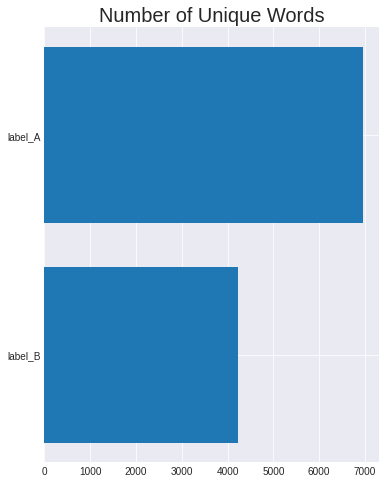

In [ ]:
y_pos = np.arange(len(data_words))

plt.figure(figsize = (6, 8))
plt.barh(y_pos, data_unique_sort.unique_words, align = 'center')
plt.yticks(y_pos, data_unique_sort.category)
plt.title('Number of Unique Words', fontsize = 20)
plt.show()

In [ ]:
import random
Train, Test = train_test_split(train_data, test_size = 0.05, random_state = RANDOM_SEED) # Splits Dataset into Training and Testing set
print("Train Data size:", len(Train))
print("Test Data size", len(Test))

Train Data size: 8550
Test Data size 450


In [ ]:
Test.shape

(450, 3)

In [ ]:
Train.head()

,label,text,processed_text
3831,0,this one's called dirty deeds done with sheep,ones called dirty deeds done sheep
3015,0,the look after being told something idiotic be...,look told something idiotic like
3606,1,how come every week black police don't kill un...,every week black police dont kill unarmed whit...
1099,0,wnen you're walking home and come across a nak...,wnen youre walking home across naked corpse sh...
1396,1,no matter what anyone tells you racism is ok,matter anyone tells racism ok


In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(Train.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 9140


In [ ]:
#### Making the sentences of equal length (MAX_LENGTH) by adding padding 0
MAX_LENGTH = 100

from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(tokenizer.texts_to_sequences(Train.text), maxlen = MAX_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(Test.text),
                       maxlen = MAX_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (8550, 100)
Testing X Shape: (450, 100)


In [ ]:
# Get all the train labels

labels = Train.text.unique().tolist()

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Train.label.to_list())

y_train = encoder.transform(Train.label.to_list())
y_test = encoder.transform(Test.label.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (8550, 1)
y_test shape: (450, 1)


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-05-10 06:30:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-10 06:30:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-10 06:30:43--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
GLOVE_EMB = 'glove.6B.300d.txt'
BATCH_SIZE = 16
EPOCHS = 50
MODEL_PATH = 'best_model.hdf5'

In [ ]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [ ]:
EMBEDDING_DIM = 300

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(9140, 300)

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04656   ,  0.21318001, -0.0074364 , ...,  0.0090611 ,
        -0.20988999,  0.053913  ],
       [-0.28426999,  0.047977  , -0.15062   , ..., -0.090071  ,
         0.016922  ,  0.29278001],
       ...,
       [ 0.62057   , -0.019535  ,  0.14742   , ..., -0.11297   ,
        -0.067196  ,  0.38501999],
       [-0.047282  ,  0.35899001, -0.98430002, ...,  0.14873999,
         0.16879   , -0.27252999],
       [-0.24658   ,  0.27643001, -0.15236001, ..., -0.30061001,
         0.59130001, -0.29019001]])

In [ ]:
import tensorflow as tf

embedding_layer = tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, weights = [embedding_matrix], input_length = MAX_LENGTH, trainable = False)

In [ ]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
sequence_input = Input(shape = (MAX_LENGTH,), dtype = 'int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)

x = Conv1D(64, 5, activation = 'relu')(x)


x = Bidirectional(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))(x)

x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)

x = Dense(64, activation = 'relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(sequence_input, outputs)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          2742000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            96064     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

In [ ]:
len(model.layers)

10

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

LR = 1e-3

model.compile(optimizer = Adam(learning_rate = LR), loss = 'binary_crossentropy', metrics = ['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor = 0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

In [ ]:
history = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_test, y_test), callbacks = [ReduceLROnPlateau])

Epoch 1/50
535/535 [==============================] - 131s 232ms/step - loss: 0.6607 - accuracy: 0.6229 - val_loss: 0.6347 - val_accuracy: 0.6622
Epoch 2/50
535/535 [==============================] - 126s 236ms/step - loss: 0.5878 - accuracy: 0.7061 - val_loss: 0.6007 - val_accuracy: 0.6956
Epoch 3/50
535/535 [==============================] - 126s 235ms/step - loss: 0.5471 - accuracy: 0.7348 - val_loss: 0.5923 - val_accuracy: 0.7089
Epoch 4/50
535/535 [==============================] - 125s 233ms/step - loss: 0.5161 - accuracy: 0.7599 - val_loss: 0.6043 - val_accuracy: 0.6756
Epoch 5/50
535/535 [==============================] - 124s 232ms/step - loss: 0.4870 - accuracy: 0.7693 - val_loss: 0.6977 - val_accuracy: 0.6578
Epoch 6/50
535/535 [==============================] - 127s 237ms/step - loss: 0.4256 - accuracy: 0.8012 - val_loss: 0.6894 - val_accuracy: 0.6556
Epoch 7/50
535/535 [==============================] - 134s 251ms/step - loss: 0.4139 - accuracy: 0.8023 - val_loss: 0.7700 -

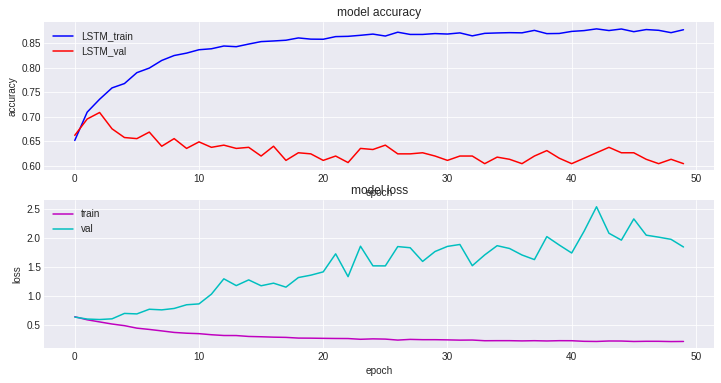

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c = 'b')
at.plot(history.history['val_accuracy'], c ='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc ='upper left')

al.plot(history.history['loss'], c ='m')
al.plot(history.history['val_loss'], c ='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
def decode_sentiment(score):

    return 1 if score > 0.5 else 0

scores = model.predict(X_test, verbose = 1, batch_size = 100)
y_pred_1d = [decode_sentiment(score) for score in scores]

5/5 [==============================] - 1s 99ms/step


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 13)
    plt.yticks(tick_marks, classes, fontsize = 13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize = 17)
    plt.xlabel('Predicted label', fontsize = 17)

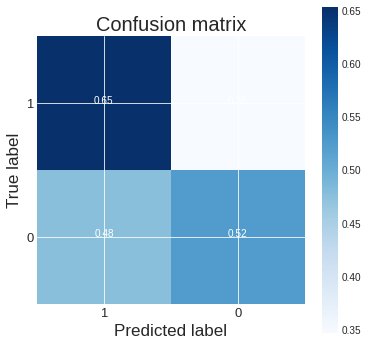

In [ ]:
cnf_matrix = confusion_matrix(Test.label.to_list(), y_pred_1d)
plt.figure(figsize = (6,6))
plot_confusion_matrix(cnf_matrix, classes = Test.label.unique(), title = "Confusion matrix")
plt.show()

In [ ]:
print(classification_report(list(Test.label), y_pred_1d))

              precision    recall  f1-score   support

           0       0.69      0.65      0.67       280
           1       0.48      0.52      0.50       170

    accuracy                           0.60       450
   macro avg       0.59      0.59      0.59       450
weighted avg       0.61      0.60      0.61       450

